### Описание проекта
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

#### Описание данных
 - Name — название игры
 - Platform — платформа
 - Year_of_Release — год выпуска
 - Genre — жанр игры
 - NA_sales — продажи в Северной Америке (миллионы проданных копий)
 - EU_sales — продажи в Европе (миллионы проданных копий)
 - JP_sales — продажи в Японии (миллионы проданных копий)
 - Other_sales — продажи в других странах (миллионы проданных копий)
 - Critic_Score — оценка критиков (максимум 100)
 - User_Score — оценка пользователей (максимум 10)
 - Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Оглавление

1. [Общая информация](#1)
2. [Предобработка данных](#2)
      - 2.1 [Корректировка названий колонок](#2.1)
      - 2.2 [Обработка пропусков](#2.2)
      - 2.3 [Преобразование типов данных](#2.3)
      - 2.4 [Суммарные продажи](#2.4)
3. [Исследовательский анализ данных](#3)
   - 3.1 [Выход игр по годам](#3.1)
   - 3.2 [Суммарные продажи по платформам за всё время](#3.2)
   - 3.3 [Характерная продолжительность присутствия платформ на рынке](#3.3)
   - 3.4 [Данные за актуальный период (последние 10 лет)](#3.4)
   - 3.5 ["Ящики с усами" для актуальных платформ за последние 10 лет](#3.5)
   - 3.6 [Корреляция между отзывами и продажами](#3.6)
   - 3.7 [Распределение игр по жанрам](#3.7)
4. [Портрет пользователя каждого региона](#4)
    - 4.1 [Регион NA](#4.1)
    - 4.2 [Регион EU](#4.2)
    - 4.3 [Регион JP](#4.3)
5. [Проверка гипотез](#5)
    - 5.1 [Гипотеза 1](#5.1)
    - 5.2 [Гипотеза 2](#5.2)
6. [Общий вывод](#6)

### 1. Общая информация <a id="1"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
df_games = pd.read_csv('/datasets/games.csv')
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### 2. Подготовка данных <a id="2"></a>

#### 2.1 Корректировка названий колонок <a id="2.1"></a>

In [3]:
#привдем названия столбцов к нижнему регистру
df_games.columns = [x.lower() for x in df_games.columns]
df_games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### 2.2 Обработка пропусков <a id="2.2"></a>

- в колонках 'critic_score' и 'user_score' заполним пропуски значением "-1", чтобы в последющем легко отфильтровывать данные без оценок;
- что касается аббревиатуры 'tbd' в колонке 'user_score', то она обозначает, что рейтинг еще не определен,скорее всего из-за малого кол-ва оценок и отзывов, заменим его значением "-1";
- удалим строк с неизвестным годом выхода игры. Кол-во таких строк 269, что составляет 1.6 процента от общего кол-ва строк;
- в колонке 'rating' пока оставим всё как есть.
- значения в колонках 'critic_score', 'user_score' как правило не имеют ярко выраженной корреляции друг с другом и с кол-вом проданных копий, поэтому нет возможности заполнить пропуски на основании имеющихся данных.

In [4]:
#заполним пропуски в колонке 'user_score'
df_games['user_score'] = df_games['user_score'].fillna(-1)

In [5]:
#заполним пропуски в колонке 'critic_score'
df_games['critic_score'] = df_games['critic_score'].fillna(-1)
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16715 non-null float64
user_score         16715 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
#заменим 'tbd' на -1 в колонке 'user_score'
df_games['user_score'] = df_games['user_score'].where(df_games['user_score'] != 'tbd', -1)

In [7]:
#удалим строки с неизвестным годом выхода игры
df_games = df_games.query('year_of_release > 0').reset_index(drop=True)
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16446 entries, 0 to 16445
Data columns (total 11 columns):
name               16444 non-null object
platform           16446 non-null object
year_of_release    16446 non-null float64
genre              16444 non-null object
na_sales           16446 non-null float64
eu_sales           16446 non-null float64
jp_sales           16446 non-null float64
other_sales        16446 non-null float64
critic_score       16446 non-null float64
user_score         16446 non-null object
rating             9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### 2.3 Преобразование типов данных <a id="2.3"></a>

In [8]:
#преобразуем данные в колонке "year_of_release" к формату int
df_games['year_of_release'] = df_games['year_of_release'].astype('int')

In [9]:
#преобразуем числовые данные в колонке "user_score" к формату float предварительно заполнив пропуски нулями   
df_games['user_score'] = df_games['user_score'].astype('float')
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16446 entries, 0 to 16445
Data columns (total 11 columns):
name               16444 non-null object
platform           16446 non-null object
year_of_release    16446 non-null int64
genre              16444 non-null object
na_sales           16446 non-null float64
eu_sales           16446 non-null float64
jp_sales           16446 non-null float64
other_sales        16446 non-null float64
critic_score       16446 non-null float64
user_score         16446 non-null float64
rating             9768 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


#### 2.4 Суммарные продажи <a id="2.4"></a>

In [10]:
#добавим колонку с суммарными продажами игр по регионам
df_games['total_sales'] = df_games['na_sales'] + df_games['eu_sales'] + df_games['jp_sales'] + df_games['other_sales']
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16446 entries, 0 to 16445
Data columns (total 12 columns):
name               16444 non-null object
platform           16446 non-null object
year_of_release    16446 non-null int64
genre              16444 non-null object
na_sales           16446 non-null float64
eu_sales           16446 non-null float64
jp_sales           16446 non-null float64
other_sales        16446 non-null float64
critic_score       16446 non-null float64
user_score         16446 non-null float64
rating             9768 non-null object
total_sales        16446 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


### 3. Исследовательский анализ данных <a id="3"></a>

#### 3.1 Выход игр по годам <a id="3.1"></a>

Text(0.5, 0, 'Год')

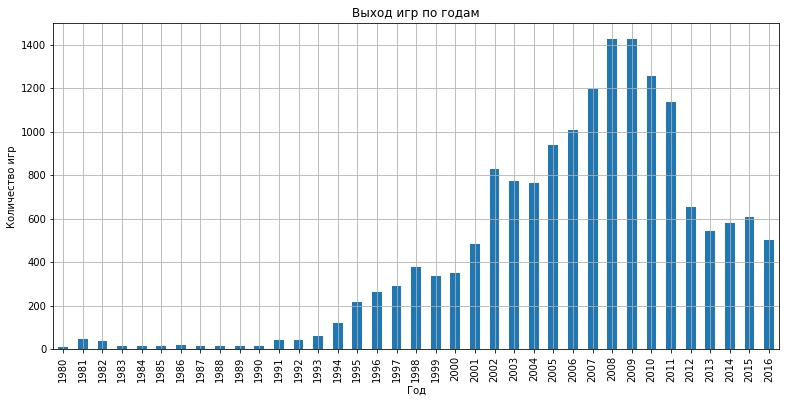

In [11]:
# суммарный выход игр по годам
df_games.groupby('year_of_release')['name'].count().plot(kind='bar', title='Выход игр по годам',grid=True, rot=90, figsize=(13,6))
plt.ylabel('Количество игр')
plt.xlabel('Год')

In [12]:
# заметно что с 1991 года наметилс рост выпуска игр. Оставим данные только после 1991
df_games_act = df_games.query('year_of_release > 1990').reset_index(drop=True)
df_games_act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16225 entries, 0 to 16224
Data columns (total 12 columns):
name               16223 non-null object
platform           16225 non-null object
year_of_release    16225 non-null int64
genre              16223 non-null object
na_sales           16225 non-null float64
eu_sales           16225 non-null float64
jp_sales           16225 non-null float64
other_sales        16225 non-null float64
critic_score       16225 non-null float64
user_score         16225 non-null float64
rating             9766 non-null object
total_sales        16225 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


#### Вывод
Видно, что с 1991-го года наметился рост кол-ва выпускаемых игр. Оставим данные, начиная с 1991-го года.

#### 3.2 Суммарные продажи по платформам за всё время <a id="3.2"></a>

Text(0.5, 0, 'Платформа')

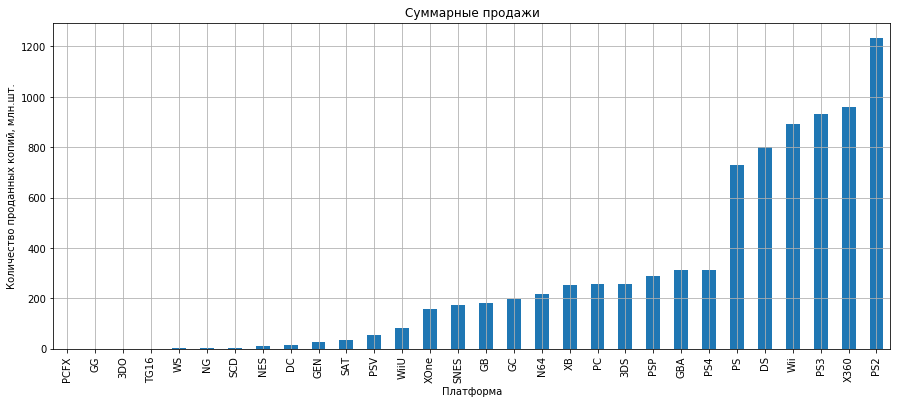

In [13]:
# суммарные продажи по платформам за всё время
df_games_total = df_games_act.groupby(['platform'])['total_sales'].sum().sort_values()
df_games_total.plot(kind='bar',grid=True, title='Суммарные продажи', rot=90, figsize=(15,6))
plt.ylabel('Количество проданных копий, млн.шт.')
plt.xlabel('Платформа')

#### 3.3 Характерная продолжительность присутствия платформ на рынке <a id="3.3"></a>

In [14]:
#оставим только платформы начиная с XOne
total_top = df_games_total['XOne':]
df_games_total_top = df_games_act.query('platform in @total_top.index').reset_index(drop=True)

#почитаем характерную продолжительность присутствия платформ на рынке
mean_time = df_games_total_top.groupby(['year_of_release','platform'])['total_sales'].sum().unstack().count().mean()
print('Характерная продолжительность присутствия платформ на рынке', round(mean_time), 'лет')

Характерная продолжительность присутствия платформ на рынке 10 лет


#### 3.4 Данные за актуальный период (последние 10 лет) <a id="3.4"></a>

In [15]:
#отберем данные по играм выпущенным после 2005-го года
df_games_10_years = df_games.query('year_of_release > 2005').reset_index(drop=True)
df_games_10_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10333 entries, 0 to 10332
Data columns (total 12 columns):
name               10333 non-null object
platform           10333 non-null object
year_of_release    10333 non-null int64
genre              10333 non-null object
na_sales           10333 non-null float64
eu_sales           10333 non-null float64
jp_sales           10333 non-null float64
other_sales        10333 non-null float64
critic_score       10333 non-null float64
user_score         10333 non-null float64
rating             6604 non-null object
total_sales        10333 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 968.8+ KB


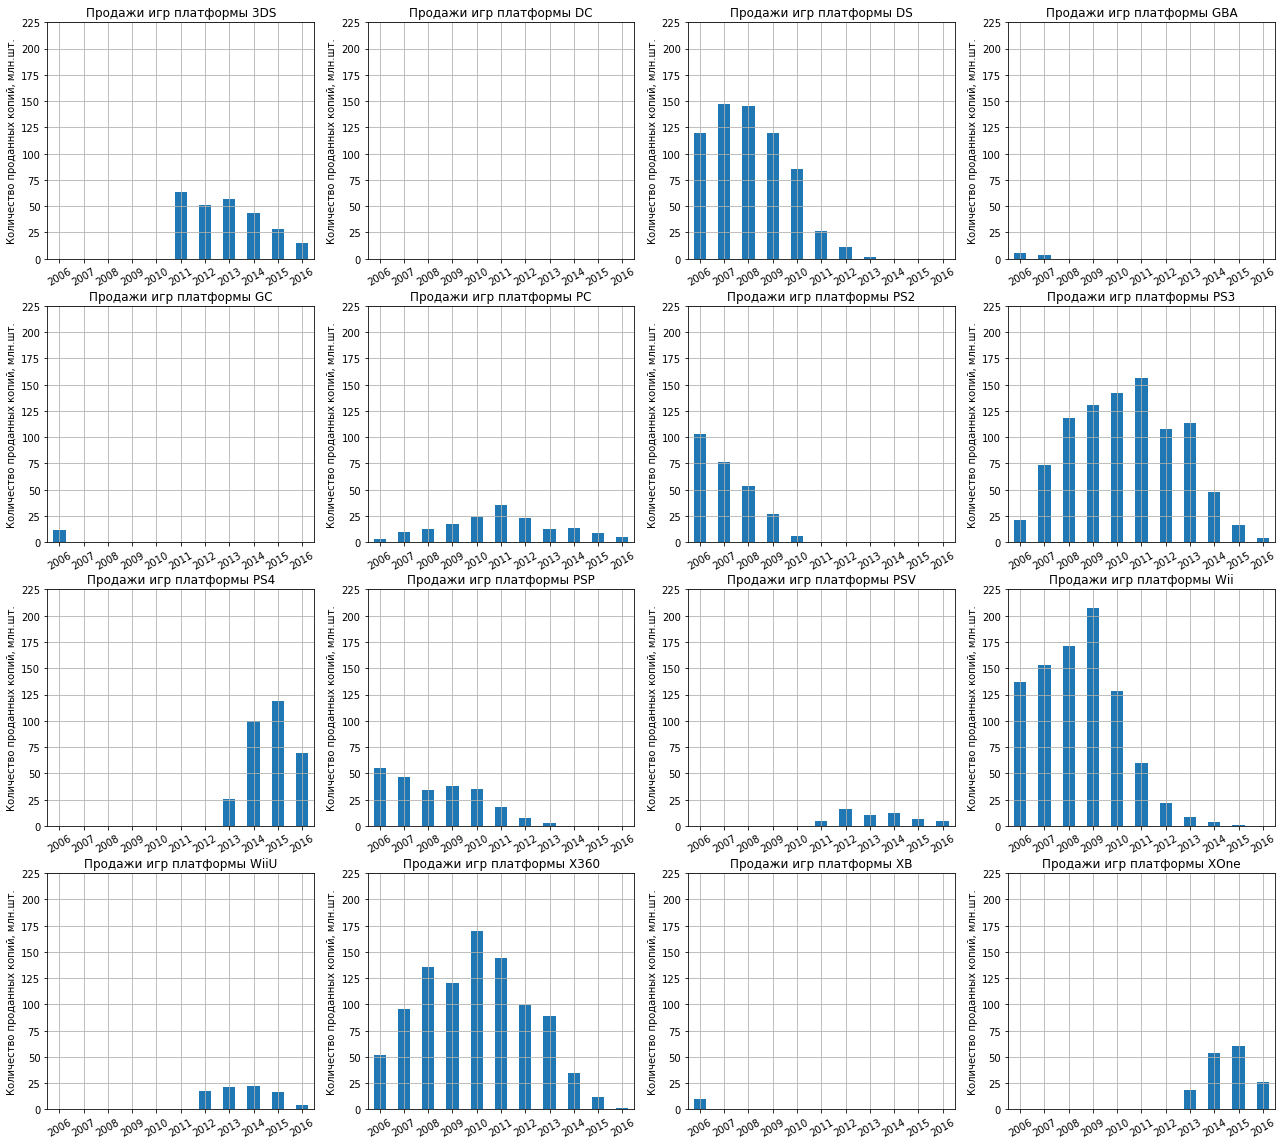

In [16]:
#построим графики суммарных продаж по платформам
df_games_10_years_group = df_games_10_years.groupby(['year_of_release','platform'])['total_sales'].sum()

df_games_10_years_un = df_games_10_years_group.unstack()
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize=(22,20))
n = 0
m = 0
for col in df_games_10_years_un.columns:
    if n <= 3:
        df_games_10_years_un[col].plot(kind='bar',grid=True, rot=30,ax=axes[m,n])
        axes[m,n].set_xlabel('')
        axes[m,n].set_ylabel('Количество проданных копий, млн.шт.')
        axes[m,n].set_title(f'Продажи игр платформы {col}')
        axes[m,n].set_ylim([0, 225])
        n += 1
    else:
        n=0
        m += 1
        df_games_10_years_un[col].plot(kind='bar',grid=True, rot=30,ax=axes[m,n])
        axes[m,n].set_xlabel('')
        axes[m,n].set_ylabel('Количество проданных копий, млн.шт.')
        axes[m,n].set_title(f'Продажи игр платформы {col}')
        axes[m,n].set_ylim([0, 225])
        n += 1


#### Выводы:

 - в ходе анализа мы выяснили, что характерная продолжительность присутствия платформ на рынке составляет 10 лет;
 - актуальными платформами будем считать те, у которых не закончилась характерная продолжительность присутствия на рынке. А именно - 3DS, PS4, PSV, WiiU, XOne. Также не стоит отбрасывать PC;
 - ни у одной из вышеперечисленных платформ не наблюдается роста продаж в 2016 году относительно 2015 года. Можно предположить, что данные за 2016 год не окончательные;
 - лидерами по продажам игр в последние годы можно считать PS4 и XOne;
 - актуальным периодом будем считать последние 4 года(включая 2016-й), будем ориентироваться на лидеров рынка (PS4 и XOne), то есть рассмотрим какие тренды наметились за период, прошедший с выхода этих платформ.

#### 3.5 "Ящики с усами" для актуальных платформ за последние 4 года <a id="3.5"></a>

Text(0.5, 0, 'Платформа')

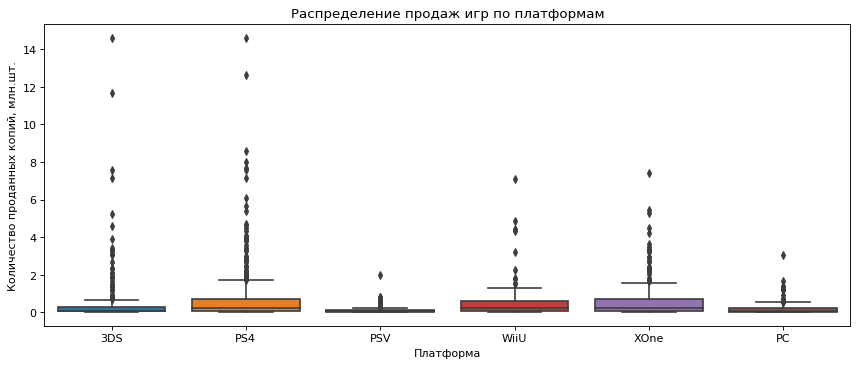

In [17]:
#отфильтруем данные за 4 года
df_games_4_years = df_games_10_years.query('year_of_release > 2012').reset_index(drop=True)
df_games_4_years_group = df_games_4_years.pivot_table(index='name', columns = 'platform', values='total_sales')

#построим ящики с усами для вышеперечисленных платформ
plt.figure(figsize=(13,5), dpi= 80)
ax = sns.boxplot(data=df_games_4_years_group[['3DS', 'PS4', 'PSV', 'WiiU', 'XOne','PC']])
plt.title('Распределение продаж игр по платформам')
plt.ylabel('Количество проданных копий, млн.шт.')
plt.xlabel('Платформа')

In [18]:
df_games_4_years_group[['3DS', 'PS4', 'PSV', 'WiiU', 'XOne','PC']].describe()

platform,3DS,PS4,PSV,WiiU,XOne,PC
count,303.000000,392.000000,358.000000,115.000000,247.000000,189.000000
mean,0.472772,0.801378,0.092151,0.562000,0.645020,0.208624
std,1.381347,1.609456,0.153816,1.038778,1.036139,0.352304
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.040000,0.060000,0.020000,0.060000,0.060000,0.030000
50%,0.090000,0.200000,0.040000,0.200000,0.220000,0.080000
75%,0.280000,0.730000,0.110000,0.595000,0.685000,0.230000
max,14.600000,14.630000,1.960000,7.090000,7.390000,3.050000


#### Выводы:

 - судя по диаграммам, на всех платформах большинство игр продается тиражом не более 1 млн. копий. 

#### 3.6 Корреляция между отзывами и продажами <a id="3.6"></a>

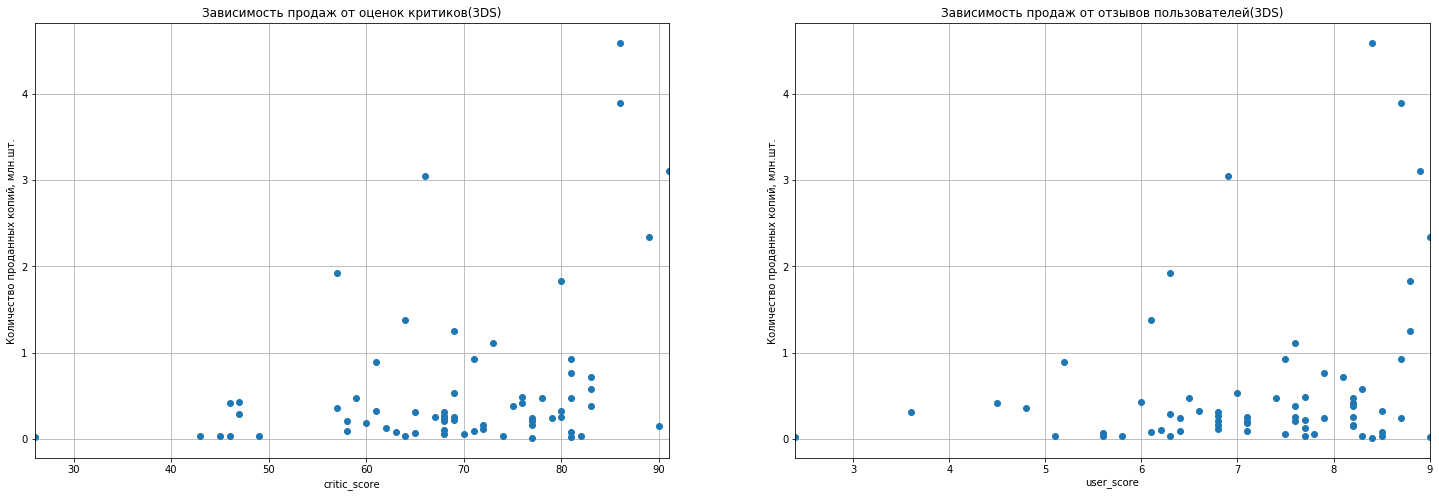

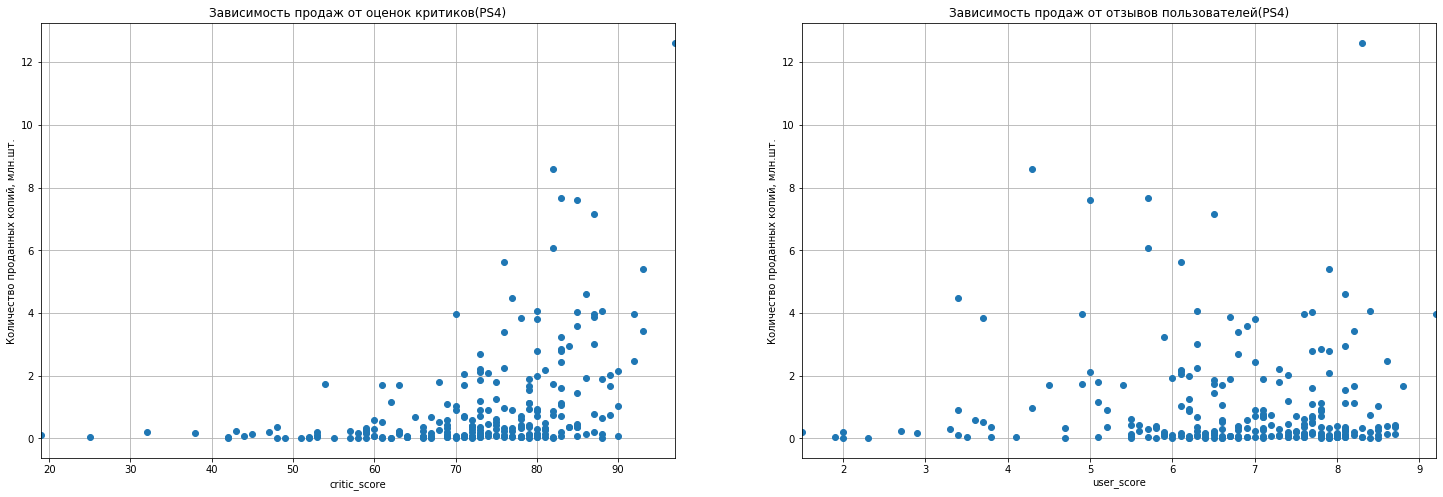

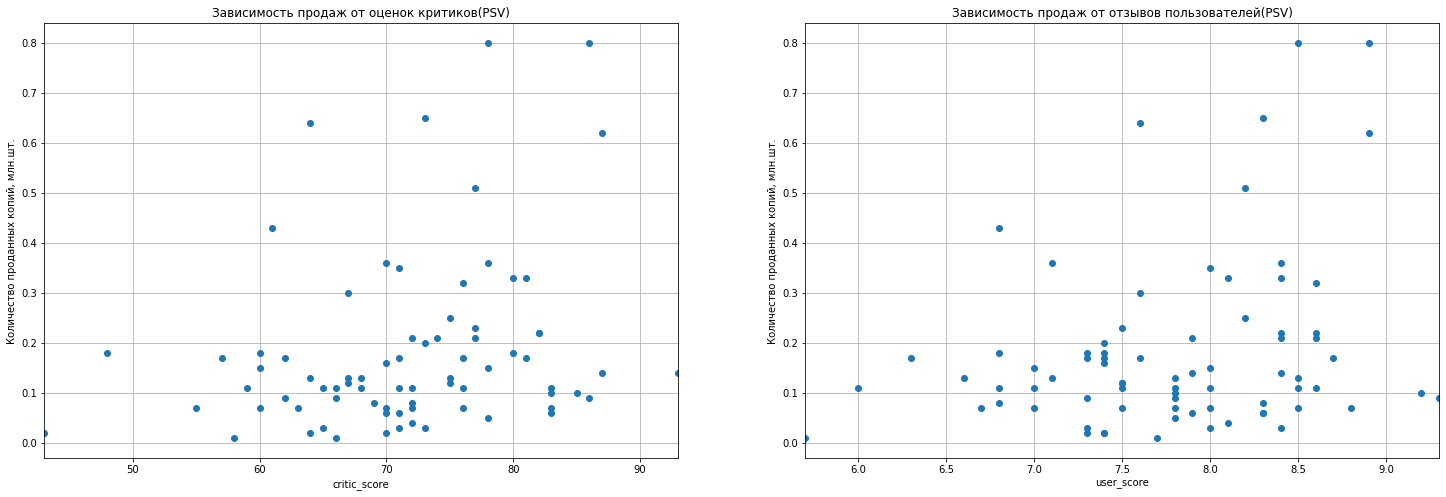

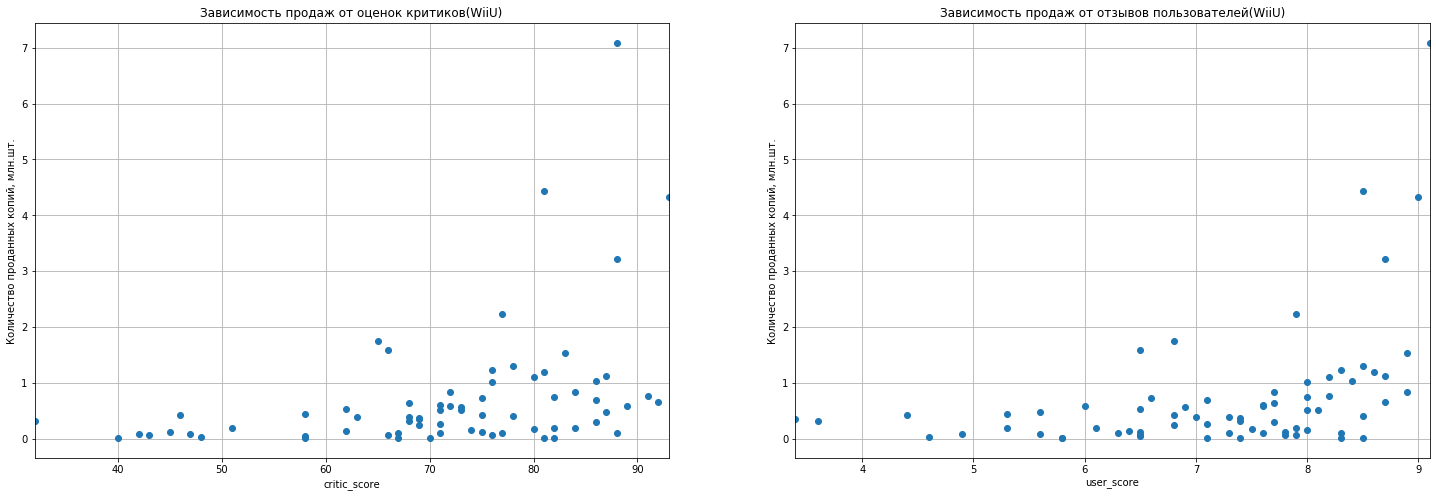

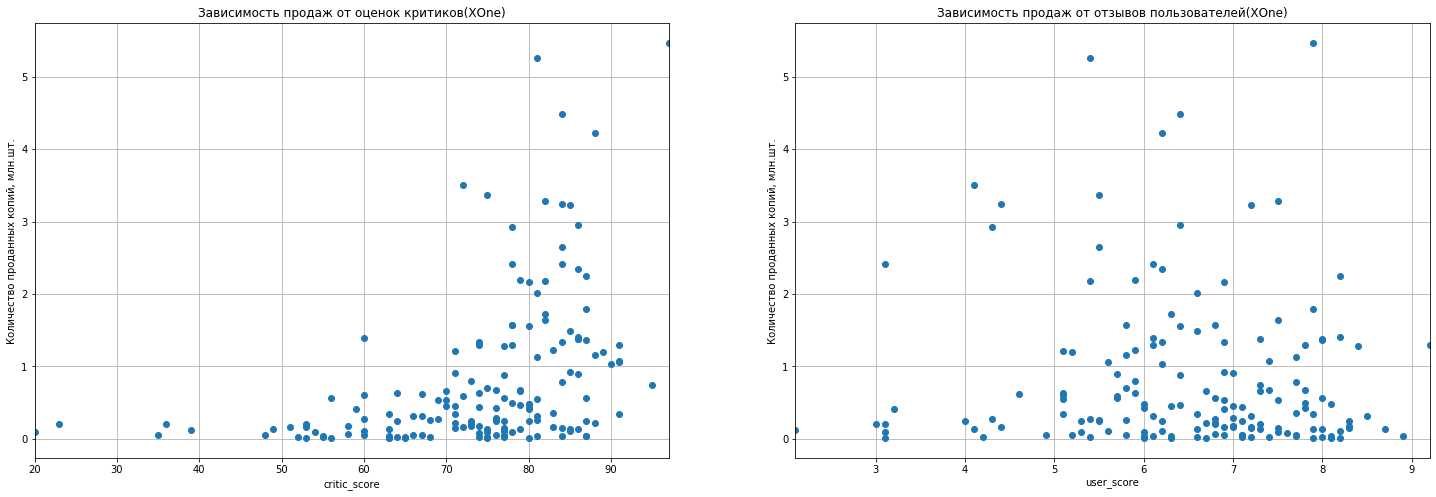

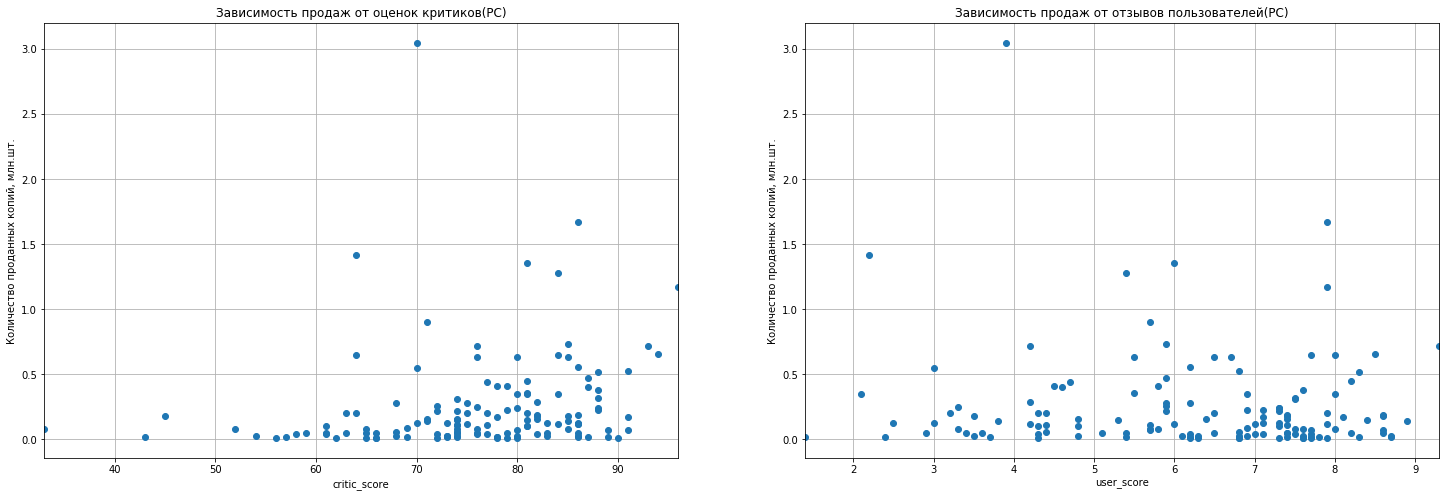

In [19]:
#отфильтруем данные для платформ и построим диаграмма рассеяния
plat = ['3DS', 'PS4', 'PSV', 'WiiU', 'XOne','PC']

for item in plat:
    df_games_ps4 = df_games_4_years.query(f'platform=="{item}" and critic_score>0 and user_score>0').dropna().reset_index(drop=True)

    fig, axes = plt.subplots(ncols = 2, figsize=(25,8))

    axes[0].set_ylabel('Количество проданных копий, млн.шт.')
    axes[0].set_xlabel('Оценок критиков')

    df_games_ps4.plot(x = 'critic_score', 
              y = 'total_sales', ax=axes[0], style='o', grid=True, title = f'Зависимость продаж от оценок критиков({item})', legend=False)
    axes[1].set_ylabel('Количество проданных копий, млн.шт.')
    axes[1].set_xlabel('Отзывов пользователей')

    df_games_ps4.plot(x = 'user_score', 
              y = 'total_sales', ax=axes[1],style='o', grid=True, title = f'Зависимость продаж от отзывов пользователей({item})', legend=False)

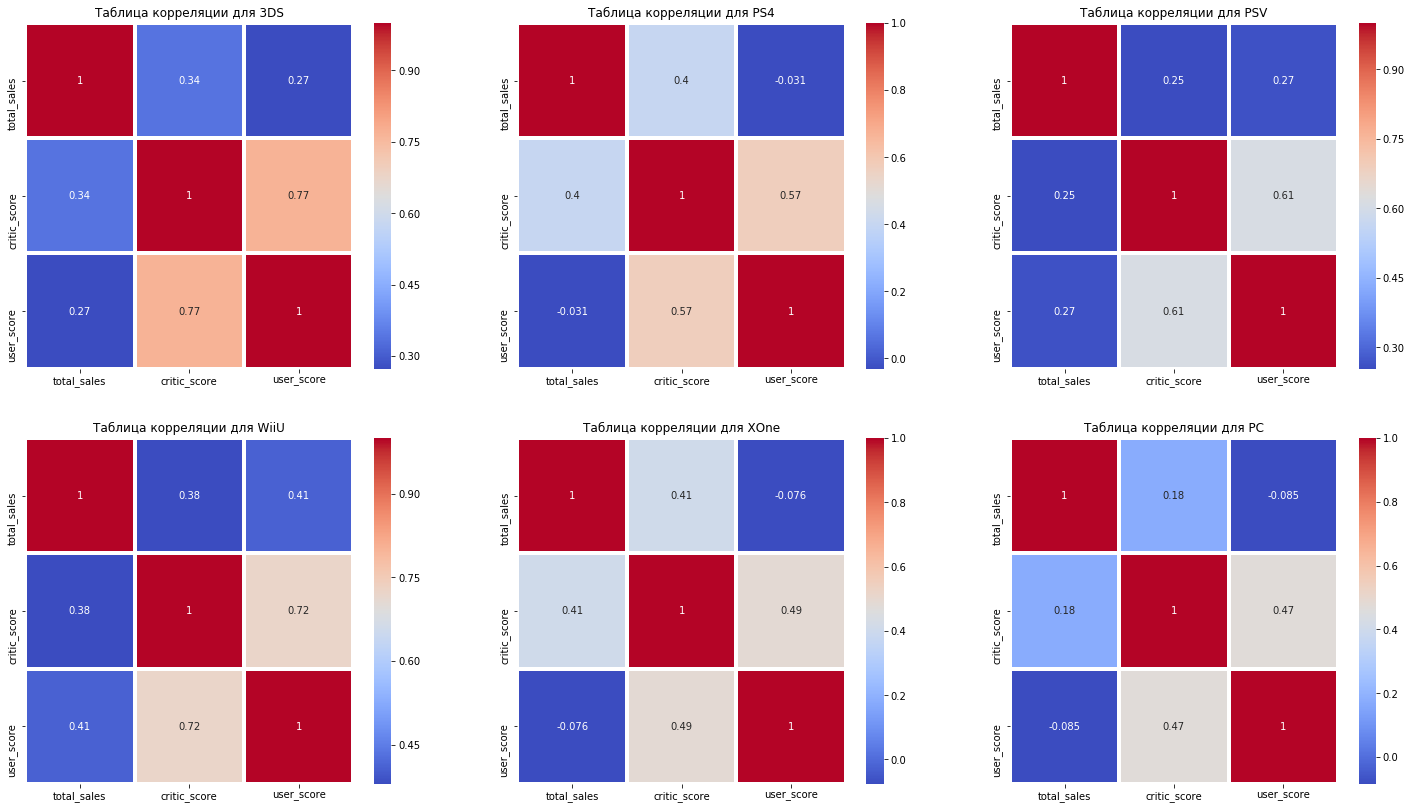

In [20]:
#выведем таблицы корреляции
plat = ['3DS', 'PS4', 'PSV', 'WiiU', 'XOne','PC']

fig, axes = plt.subplots(nrows=2, ncols = 3, figsize=(25,14))
m,n = 0,0

for item in plat:
    axes[m,n].set_title(f'Таблица корреляции для {item}')
    df_games_ps4 = df_games_4_years.query(f'platform=="{item}" and critic_score>0 and user_score>0').dropna().reset_index(drop=True)
    sns.heatmap(df_games_ps4[['total_sales','critic_score','user_score']].corr(), annot=True, cmap= 'coolwarm', linewidths=3, linecolor='white', ax=axes[m,n])
    n+=1
    if n==3:
        n=0
        m+=1


#### Вывод
 - для 3DS наблюдается слабая* корреляция между оценками критиков и продажами, также слабая корреляция между оценками пользователей и продажами;
 - для PS4 наблюдается умеренная корреляция между оценками критиков и продажами, корреляция между оценками пользователей и продажами не наблюдается;
 - для PSV наблюдается слабая корреляция между оценками критиков и продажами, также слабая корреляция между оценками пользователей и продажами;
 - для WiiU наблюдается слабая корреляция между оценками критиков и продажами, также умеренная корреляция между оценками пользователей и продажами;
 - для XOne наблюдается умеренная корреляция между оценками критиков и продажами, корреляция между оценками пользователей и продажами не наблюдается;
 - для PC наблюдается слабая корреляция между оценками критиков и продажами, корреляция между оценками пользователей и продажами не наблюдается.
 
*здесь и далее оценка силы корреляции взята из таблицы Чеддока

 #### 3.7 Распределение игр по жанрам <a id="3.7"></a>

Text(0, 0.5, '')

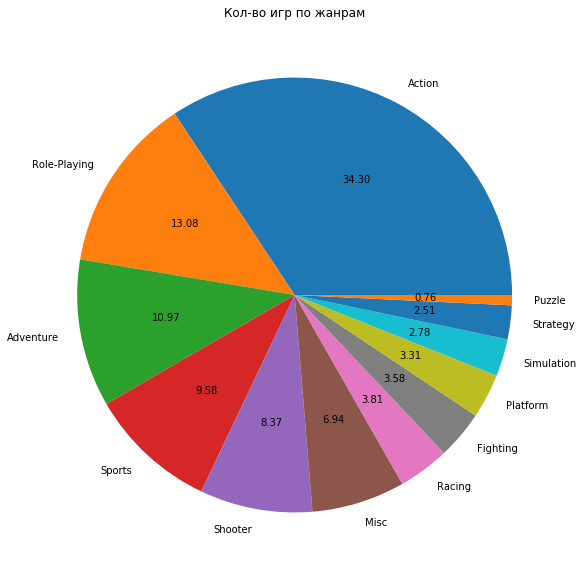

In [21]:
# кол-во выпущенных игр по жанрам
df_games_4_years.groupby('genre')['total_sales'].count().sort_values(ascending=False).plot(kind='pie',grid=True,autopct="%.2f", title='Кол-во игр по жанрам', figsize=(10,10))
plt.ylabel('')

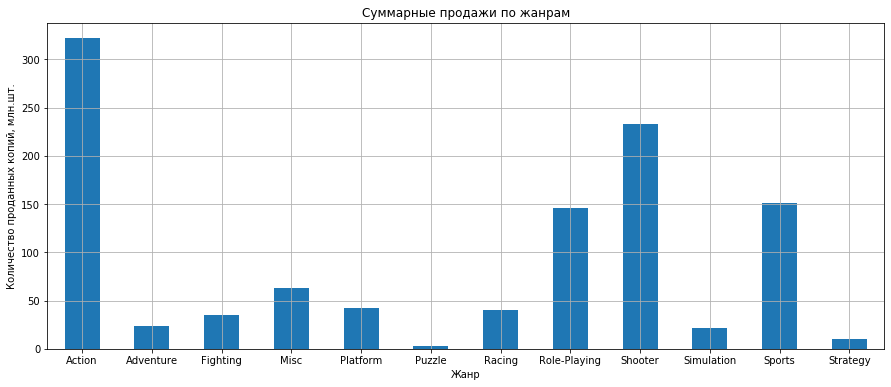

In [22]:
#кол-во выпущенных игр и кол-во проданных копий
df_games_4_years.groupby('genre')['total_sales'].sum().plot(kind='bar',grid=True, title='Суммарные продажи по жанрам', rot=0, figsize=(15,6))
plt.ylabel('Количество проданных копий, млн.шт.')
plt.xlabel('Жанр')
plt.show()

#### Вывод
 - наиболее прибыльные жанры: Action, Shooter, Sports, Role-Playing;
 - наименее прибыльные: Puzzle, Strategy, Simulation.

### Шаг 4. Портрет пользователя каждого региона <a id="4"></a>

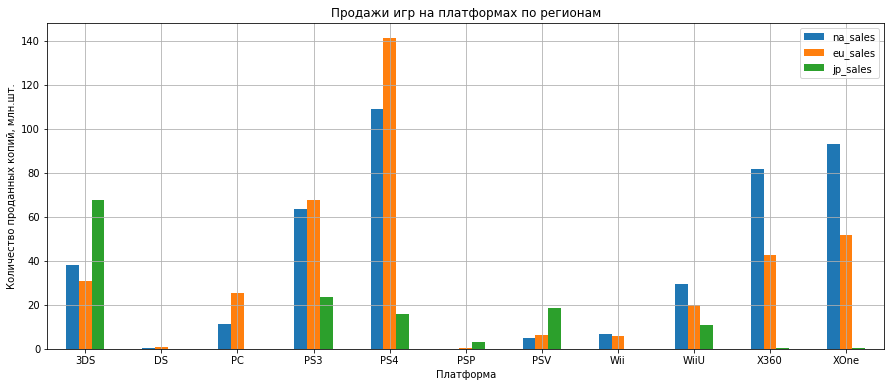

In [33]:
# популярность платформ по регионам
df_games_4_years.groupby('platform')[['na_sales','eu_sales','jp_sales']].sum().plot(kind='bar',grid=True, title='Продажи игр на платформах по регионам', rot=0, figsize=(15,6))
plt.ylabel('Количество проданных копий, млн.шт.')
plt.xlabel('Платформа')
plt.show()

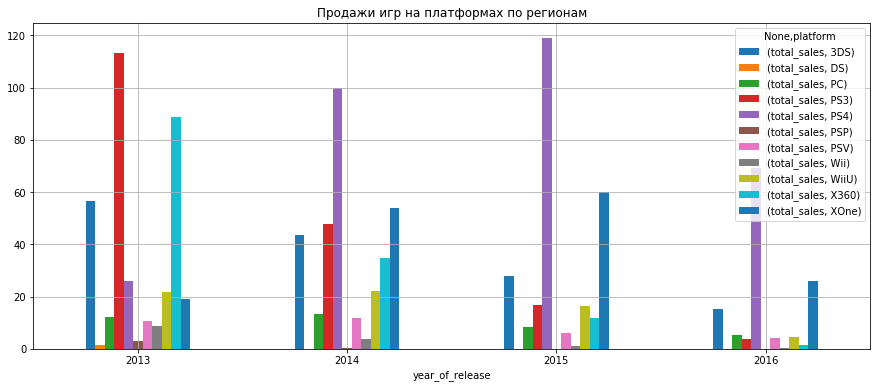

In [40]:
#df_games_4_years.groupby('year_of_release','platform')[['total_sales']].sum().plot(kind='bar',grid=True, title='Продажи игр на платформах по регионам', rot=0, figsize=(15,6))
df_games_4_years.groupby(['year_of_release','platform'])[['total_sales']].sum().unstack().plot(kind='bar',grid=True, title='Продажи игр на платформах по регионам', rot=0, figsize=(15,6))


In [24]:
df_games_4_years['rating'].value_counts()

M       369
T       333
E       302
E10+    252
Name: rating, dtype: int64

#### 4.1 Регион NA <a id="4.1"></a>

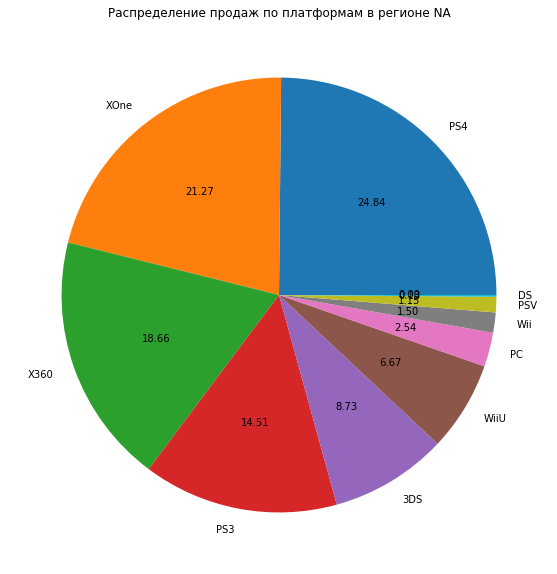

In [25]:
# популярность платформ в регионе NA
df_games_4_years.groupby('platform')['na_sales'].sum().sort_values(ascending=False).plot(kind='pie',label='', grid=True,autopct="%.2f", title='Распределение продаж по платформам в регионе NA', figsize=(10,10))

In [26]:
# топ-5 платформ в регионе NA
print('Топ-5 платформ в регионе NA')
df_games_4_years.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head()

Топ-5 платформ в регионе NA


platform
PS4     108.74
XOne     93.12
X360     81.66
PS3      63.50
3DS      38.20
Name: na_sales, dtype: float64

In [27]:
# популярные жанры в регионе NA
df_games_4_years.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head()

genre
Action          126.05
Shooter         109.74
Sports           65.27
Role-Playing     46.40
Misc             27.49
Name: na_sales, dtype: float64

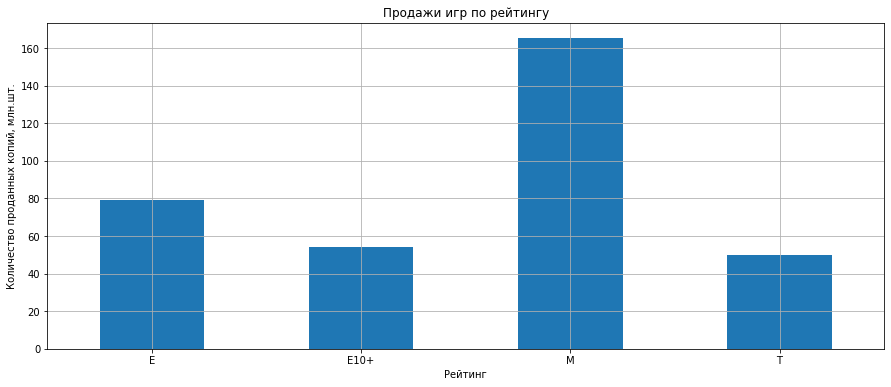

In [28]:
# влияние рейтинга в регионе NA
df_games_4_years.groupby('rating')['na_sales'].sum().plot(kind='bar',grid=True, title='Продажи игр по рейтингу', rot=0, figsize=(15,6))
plt.ylabel('Количество проданных копий, млн.шт.')
plt.xlabel('Рейтинг')
plt.show()

#### Вывод

1. Популярные платформы в регионе(процент продаж):
 - PS4 - 24.84%;
 - XOne - 21.27%;
 - X360 - 18.66%;
 - PS3 - 14.51%;
 - 3DS - 8.73%;
2. Популярные жанры:
 - Action;
 - Shooter;
 - Sports;
 - Role-Playing;
 - Misc.

#### 4.2 Регион EU <a id="4.2"></a>

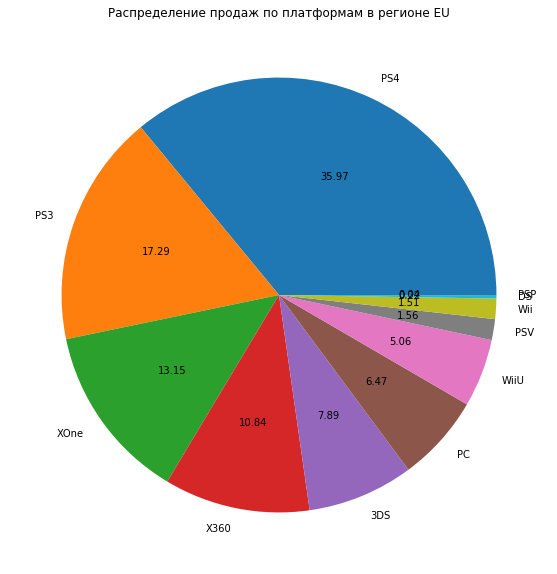

In [29]:
# популярность платформ в регионе EU
df_games_4_years.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).plot(kind='pie',label='',grid=True,autopct="%.2f", title='Распределение продаж по платформам в регионе EU', figsize=(10,10))

In [30]:
# топ-5 платформ в регионе EU
print('Топ-5 платформ в регионе EU')
df_games_4_years.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head()

Топ-5 платформ в регионе EU


platform
PS4     141.09
PS3      67.81
XOne     51.59
X360     42.52
3DS      30.96
Name: eu_sales, dtype: float64

In [31]:
# популярные жанры в регионе EU
df_games_4_years.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head()

genre
Action          118.13
Shooter          87.86
Sports           60.52
Role-Playing     36.97
Racing           20.19
Name: eu_sales, dtype: float64

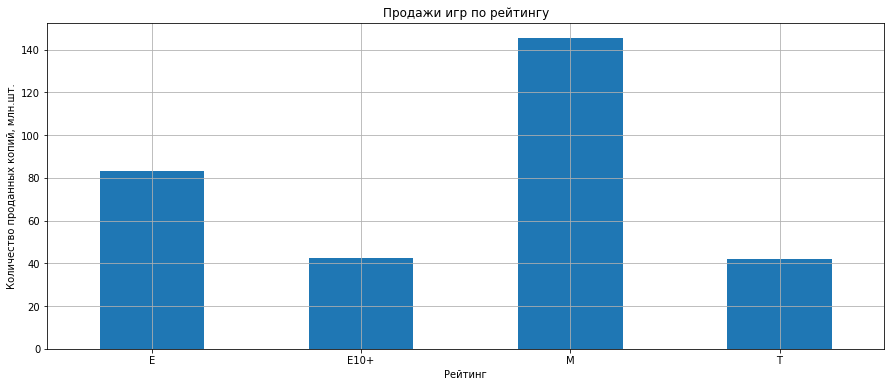

In [32]:
# влияние рейтинга в регионе EU
df_games_4_years.groupby('rating')['eu_sales'].sum().plot(kind='bar',grid=True, title='Продажи игр по рейтингу', rot=0, figsize=(15,6))
plt.ylabel('Количество проданных копий, млн.шт.')
plt.xlabel('Рейтинг')
plt.show()

#### Вывод

1. Популярные платформы в регионе(процент продаж):
 - PS4 - 35.97%;
 - PS3 - 17.29%;
 - XOne - 13.15%;
 - X360 - 10.84%;
 - 3DS - 7.89%;
 

2. Популярные жанры:
 - Action;
 - Shooter;
 - Sports;
 - Role-Playing;
 - Racing.

#### 4.3 Регион JP <a id="4.3"></a>

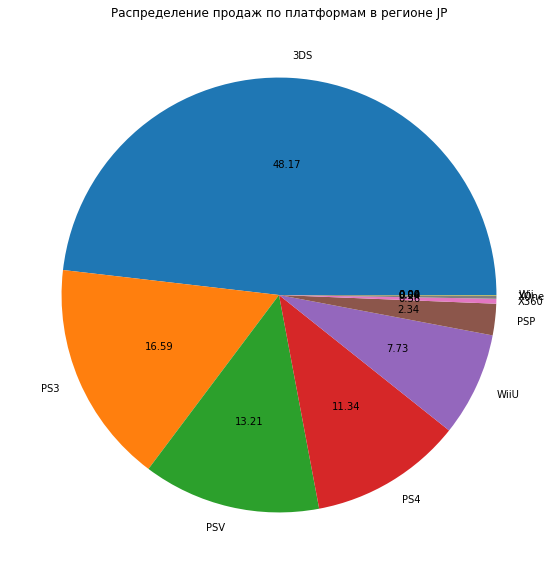

In [33]:
# популярность платформ в регионе JP
df_games_4_years.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).plot(kind='pie',label='',grid=True,autopct="%.2f", title='Распределение продаж по платформам в регионе JP', figsize=(10,10))

In [34]:
# топ-5 платформ в регионе JP
print('Топ-5 платформ в регионе JP')
df_games_4_years.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head()

Топ-5 платформ в регионе JP


platform
3DS     67.81
PS3     23.35
PSV     18.59
PS4     15.96
WiiU    10.88
Name: jp_sales, dtype: float64

In [35]:
# популярные жанры в регионе JP
df_games_4_years.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head()

genre
Role-Playing    51.04
Action          40.49
Misc             9.20
Fighting         7.65
Shooter          6.61
Name: jp_sales, dtype: float64

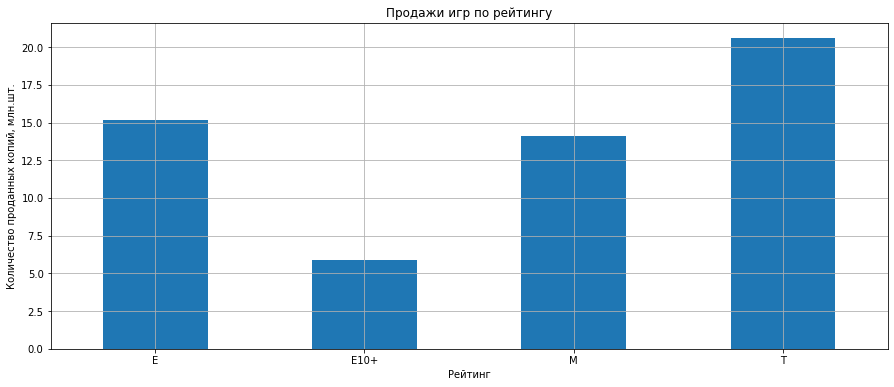

In [36]:
# влияние рейтинга в регионе JP
df_games_4_years.groupby('rating')['jp_sales'].sum().plot(kind='bar',grid=True, title='Продажи игр по рейтингу', rot=0, figsize=(15,6))
plt.ylabel('Количество проданных копий, млн.шт.')
plt.xlabel('Рейтинг')
plt.show()

#### Вывод

1. Популярные платформы в регионе(процент продаж):
 - 3DS - 48.17%;
 - PS3 - 16.59%;
 - PSV - 13.21%;
 - PS4 - 11.34%;
 - WiiU - 7.73%;


2. Популярные жанры:
 - Role-Playing;
 - Action;
 - Misc;
 - Fighting;
 - Shooter.

### Общий вывод по всем регионам

 - в регионах NA и EU состав топ-5 платформ идентичен, но порядок отличается, первое место занимают PS4;
 - в регионе JP первое место среди платформ занимает 3DS, которая занимает только 5-е место в других регионах. Также стоит отметить, что в данном регионе ни XOne, ни X360 в топ не входят;
 - поулярные жанры в регионах NA и EU отличаются только последним местом. Лидирует жанр Action;
 - в регионе JP первое место среди жанров занимает Role-Playing, Action занимает второе место;
 - в регионах NA и EU первое место по продажам занимают игры с рейтингом М, тогда как в регионе JP игры с данным рейтингом занимаюь лишь третье место, лидируют же игры с рейтингом Т.

### Шаг 5. Проверка гипотез <a id="5"></a>

#### 5.1 Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые <a id="5.1"></a>

Сформулируем нулевую гипотезу следующим образом - cредние пользовательские рейтинги платформ Xbox One и PC одинаковые. Соответственно, альтернативная гипотеза - cредние пользовательские рейтинги платформ Xbox One и PC отличаются.
Отфильтруем данные по платформам XOne и PC. Так как мы проверяем гипотезу о равенстве средних двух генеральных совокупностей, то к получившимся выборкам применим метод scipy.stats.ttest_ind.

In [37]:
#отфильтруем необходимые данные
df_games_xone = df_games_4_years.query('platform=="XOne" and user_score>-1')['user_score']
df_games_pc = df_games_4_years.query('platform=="PC" and user_score>-1')['user_score']

In [38]:
#сравним дисперсии выборок
variance_xone = np.var(df_games_xone, ddof=1)
variance_pc = np.var(df_games_pc, ddof=1)

variance_xone, variance_pc

(1.9069968429360695, 3.035892752408882)

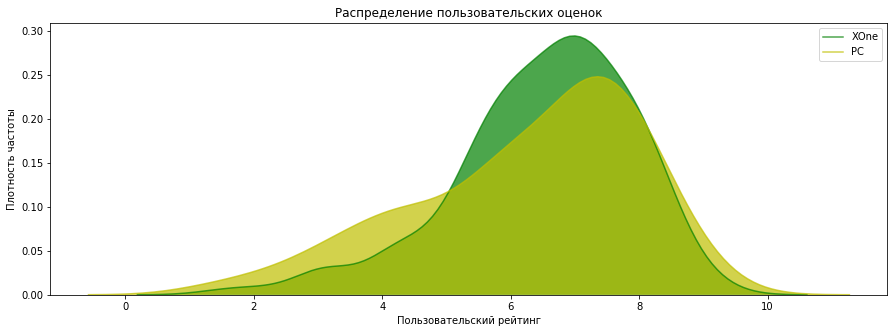

In [39]:
#построим диаграмму распределения пользовтельских оценок
fig = plt.subplots(figsize=(15,5))
ax = sns.kdeplot(df_games_xone , shade=True, color="g", alpha=.7, label='XOne')
sns.kdeplot(df_games_pc , shade=True, color="y", alpha=.7, ax=ax, label='PC')
plt.title('Распределение пользовательских оценок')
plt.ylabel('Плотность частоты')
plt.xlabel('Пользовательский рейтинг')
plt.show()

In [40]:
#проверим гипотезу о равенстве среднего двух генеральных совокупностей

#критический уровень статистической значимости
alpha = 0.05

#так как дисперсии выборок отличаются незначительно - аргумент equal_var=True
results = st.ttest_ind(df_games_xone, df_games_pc)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


#### Вывод
Гипотеза, что cредние пользовательские рейтинги платформ Xbox One и PC одинаковые, не подтверждена.

#### 5.2 Гипотеза 2. Средние пользовательские рейтинги жанров Action и Sports разные <a id="5.2"></a>

Сформулируем нулевую гипотезу следующим образом - cредние пользовательские рейтинги жанров Action и Sports одинаковые. Соответственно, альтернативная гипотеза - cредние пользовательские рейтинги жанров Action и Sports отличаются.
Отфильтруем данные по жанрам Action и Sports. Так как мы проверяем гипотезу о равенстве средних двух генеральных совокупностей, то к получившимся выборкам применим метод scipy.stats.ttest_ind.

In [41]:
#отфильтруем необходимые данные
df_games_action = df_games_4_years.query('genre=="Action" and user_score>-1')['user_score'].reset_index(drop=True)
df_games_sports = df_games_4_years.query('genre=="Sports" and user_score>-1')['user_score'].reset_index(drop=True)

In [42]:
#сравним дисперсии выборок
variance_action = np.var(df_games_action, ddof=1)
variance_sports = np.var(df_games_sports, ddof=1)
variance_action, variance_sports

(1.7693609042482705, 3.180612814465409)

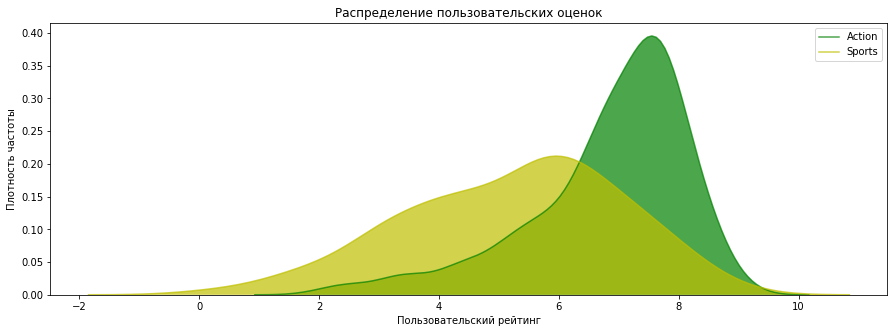

In [43]:
#построим диаграмму распределения пользовтельских оценок
fig = plt.subplots(figsize=(15,5))
ax = sns.kdeplot(df_games_action , shade=True, color="g", alpha=.7, label='Action')
sns.kdeplot(df_games_sports , shade=True, color="y", alpha=.7, ax=ax, label='Sports')
plt.title('Распределение пользовательских оценок')
plt.ylabel('Плотность частоты')
plt.xlabel('Пользовательский рейтинг')
plt.show()

In [44]:
#проверим гипотезу о равенстве среднего двух генеральных совокупностей

#критический уровень статистической значимости
alpha = 0.05

#так как дисперсии выборок отличаются незначительно - аргумент equal_var=True
results = st.ttest_ind(df_games_action, df_games_sports)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


#### Вывод
Гипотезу, что средние пользовательские рейтинги жанров Action и Sports разные, не удалось отвергнуть.

### Шаг 6. Общий вывод <a id="6"></a>

#### В ходе анализа имеющегося набора данных были проведены следующие преобразования:
- в колонках 'critic_score' и 'user_score' заполнили пропуски значением "-1", чтобы в последющем легко отфильтровывать данные без оценок;
- что касается аббревиатуры 'tbd' в колонке 'user_score', то она обозначает, что рейтинг еще не определен,скорее всего из-за малого кол-ва оценок и отзывов, заменили ее значением "-1";
- удалили строки с неизвестным годом выхода игры. Кол-во таких строк 269, что составляет 1.6 процента от общего кол-ва строк;
- добавили колонку с суммарными продажами игр.

#### В ходе анализа мы выяснили:

 - характерная продолжительность присутствия платформы на рынке составляет 10 лет;
 - потенциально прибыльными платформами будем считать те, у которых не закончилась характерная продолжительность присутствия на рынке. А именно - 3DS, PS4, PSV, WiiU, XOne. Также не стоит отбрасывать PC;
 - ни у одной из вышеперечисленных платформ не наблюдается роста продаж в 2016 году относительно 2015 года. Можно предположить, что данные за 2016 год не окончательные;
 - лидерами по продажам игр в последние годы можно считать PS4 и XOne;
 - судя по диаграммам, на всех платформах большинство игр продается тиражом не более 1 млн. копий;
 - актуальным периодом будем считать последние 4 года(включая 2016-й), будем ориентироваться на лидеров рынка (PS4 и XOne), то есть рассмотрим какие тренды наметились за период, прошедший с выхода этих платформ;
 - для 3DS наблюдается слабая* корреляция между оценками критиков и продажами, также слабая корреляция между оценками пользователей и продажами;
 - для PS4 наблюдается умеренная корреляция между оценками критиков и продажами, корреляция между оценками пользователей и продажами не наблюдается;
 - для PSV наблюдается слабая корреляция между оценками критиков и продажами, также слабая корреляция между оценками пользователей и продажами;
 - для WiiU наблюдается слабая корреляция между оценками критиков и продажами, также умеренная корреляция между оценками пользователей и продажами;
 - для XOne наблюдается умеренная корреляция между оценками критиков и продажами, корреляция между оценками пользователей и продажами не наблюдается;
 - для PC наблюдается слабая корреляция между оценками критиков и продажами, корреляция между оценками пользователей и продажами не наблюдается;
 - наиболее прибыльные жанры: Action, Shooter, Sports, Role-Playing;
 - наименее прибыльные: Puzzle, Strategy, Simulation.
 
 
#### Портрет пользователя каждого региона:

 - в регионах NA и EU состав топ-5 платформ идентичен, но порядок отличается, первое место занимают PS4;
 - в регионе JP первое место среди платформ занимает 3DS, которая занимает только 5-е место в других регионах. Также стоит отметить, что в данном регионе ни XOne, ни X360 в топ не входят;
 - поулярные жанры в регионах NA и EU отличаются только последним местом. Лидирует жанр Action;
 - в регионе JP первое место среди жанров занимает Role-Playing, Action занимает второе место;
 - в регионах NA и EU первое место по продажам занимают игры с рейтингом М, тогда как в регионе JP игры с данным рейтингом занимаюь лишь третье место, лидируют же игры с рейтингом Т.

#### Проверка гипотез

Гипотеза, что cредние пользовательские рейтинги платформ Xbox One и PC одинаковые, не подтверждена.

Гипотезу, что средние пользовательские рейтинги жанров Action и Sports разные, не удалось отвергнуть.
 
 
#### Рекомендации
 - в регионах NA и EU популярены жанры Action, Shooter, Sports, Role-Playing, соответственно, стоит сделать ставку на игры данных жанров, выходящих на платформах PS4, XOne;
 - в регионе JP популярен жанр Role-Playing, Action, Misc, Fighting, Shooter, соответственно стоит сделать ставку на игры данных жанров, выходящих на платформе 3DS.
 
 
 
 *здесь и далее оценка силы корреляции взята из таблицы Чеддока